In [60]:
!pip3 install --upgrade pip
!pip3 install -q tensorflow-macos pydot

Defaulting to user installation because normal site-packages is not writeable


In [61]:
region="us-east-1"

dataset='./dataset/ethnicity.csv'

testdata_path='./test-data'

import os
import random
testdata_images_list = os.listdir(testdata_path)
random_number = random.randint(0, len(testdata_images_list))
random_image = testdata_images_list[random_number]
rand_image_full_path = "{}/{}".format(testdata_path, random_image)
print("random image url to predict ethnicity: ", rand_image_full_path)

random image url to predict ethnicity:  ./test-data/download.jpg


In [62]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Dropout,Conv2D,MaxPooling2D,BatchNormalization,InputLayer
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt 
import sklearn as skl
from sklearn.model_selection import train_test_split
import tqdm
from tqdm import tqdm
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Image version: {Image.__version__}")
print(f"Matplotlib version: {mpl.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Padas version: {pd.__version__}")
print(f"Sci-Kit version: {skl.__version__}")

TensorFlow version: 2.10.0
Image version: 9.2.0
Matplotlib version: 3.6.0
Seaborn version: 0.12.0
Numpy version: 1.23.3
Padas version: 1.5.1
Sci-Kit version: 1.1.2


In [63]:
df  = pd.read_csv(dataset)
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [64]:
# Unique ethnicity
names_ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Other']
df['ethnicity'].unique()

array([2, 3, 4, 0, 1])

In [65]:
df['pixels'] = df['pixels'].apply(lambda x : np.array(x.split(), dtype="float32"))
df

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."
...,...,...,...,...,...
23700,99,0,1,20170120221920654.jpg.chip.jpg,"[127.0, 100.0, 94.0, 81.0, 77.0, 77.0, 74.0, 9..."
23701,99,1,1,20170120134639935.jpg.chip.jpg,"[23.0, 28.0, 32.0, 35.0, 42.0, 47.0, 68.0, 85...."
23702,99,2,1,20170110182418864.jpg.chip.jpg,"[59.0, 50.0, 37.0, 40.0, 34.0, 19.0, 30.0, 101..."
23703,99,2,1,20170117195405372.jpg.chip.jpg,"[45.0, 108.0, 120.0, 156.0, 206.0, 197.0, 140...."


In [66]:
df['pixels'] = df['pixels'].apply(lambda x : x /255)
df

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[0.5058824, 0.5019608, 0.5019608, 0.49411765, ..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[0.6431373, 0.2901961, 0.43529412, 0.65882355,..."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[0.2627451, 0.27450982, 0.2784314, 0.27450982,..."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[0.75686276, 0.77254903, 0.7764706, 0.78431374..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[0.7921569, 0.8039216, 0.81960785, 0.8235294, ..."
...,...,...,...,...,...
23700,99,0,1,20170120221920654.jpg.chip.jpg,"[0.49803922, 0.39215687, 0.36862746, 0.3176470..."
23701,99,1,1,20170120134639935.jpg.chip.jpg,"[0.09019608, 0.10980392, 0.1254902, 0.13725491..."
23702,99,2,1,20170110182418864.jpg.chip.jpg,"[0.23137255, 0.19607843, 0.14509805, 0.1568627..."
23703,99,2,1,20170117195405372.jpg.chip.jpg,"[0.1764706, 0.42352942, 0.47058824, 0.6117647,..."


In [67]:
type(df['pixels'])

pandas.core.series.Series

In [68]:
x = np.array(df['pixels'].tolist())

type(df['pixels']), df['pixels'].shape

(pandas.core.series.Series, (23705,))

In [69]:
x = x.reshape(x.shape[0],48,48,1)
x

array([[[[0.5058824 ],
         [0.5019608 ],
         [0.5019608 ],
         ...,
         [0.4627451 ],
         [0.3882353 ],
         [0.20784314]],

        [[0.50980395],
         [0.5058824 ],
         [0.5019608 ],
         ...,
         [0.45882353],
         [0.38431373],
         [0.20392157]],

        [[0.5137255 ],
         [0.5058824 ],
         [0.50980395],
         ...,
         [0.44705883],
         [0.38039216],
         [0.19607843]],

        ...,

        [[0.4745098 ],
         [0.5411765 ],
         [0.5764706 ],
         ...,
         [0.5921569 ],
         [0.5882353 ],
         [0.5803922 ]],

        [[0.45882353],
         [0.5372549 ],
         [0.57254905],
         ...,
         [0.58431375],
         [0.5803922 ],
         [0.5803922 ]],

        [[0.4509804 ],
         [0.5294118 ],
         [0.5568628 ],
         ...,
         [0.57254905],
         [0.57254905],
         [0.57254905]]],


       [[[0.6431373 ],
         [0.2901961 ],
         [0.43

In [70]:
type(x)

numpy.ndarray

In [71]:
x.shape

(23705, 48, 48, 1)

## Sample Images

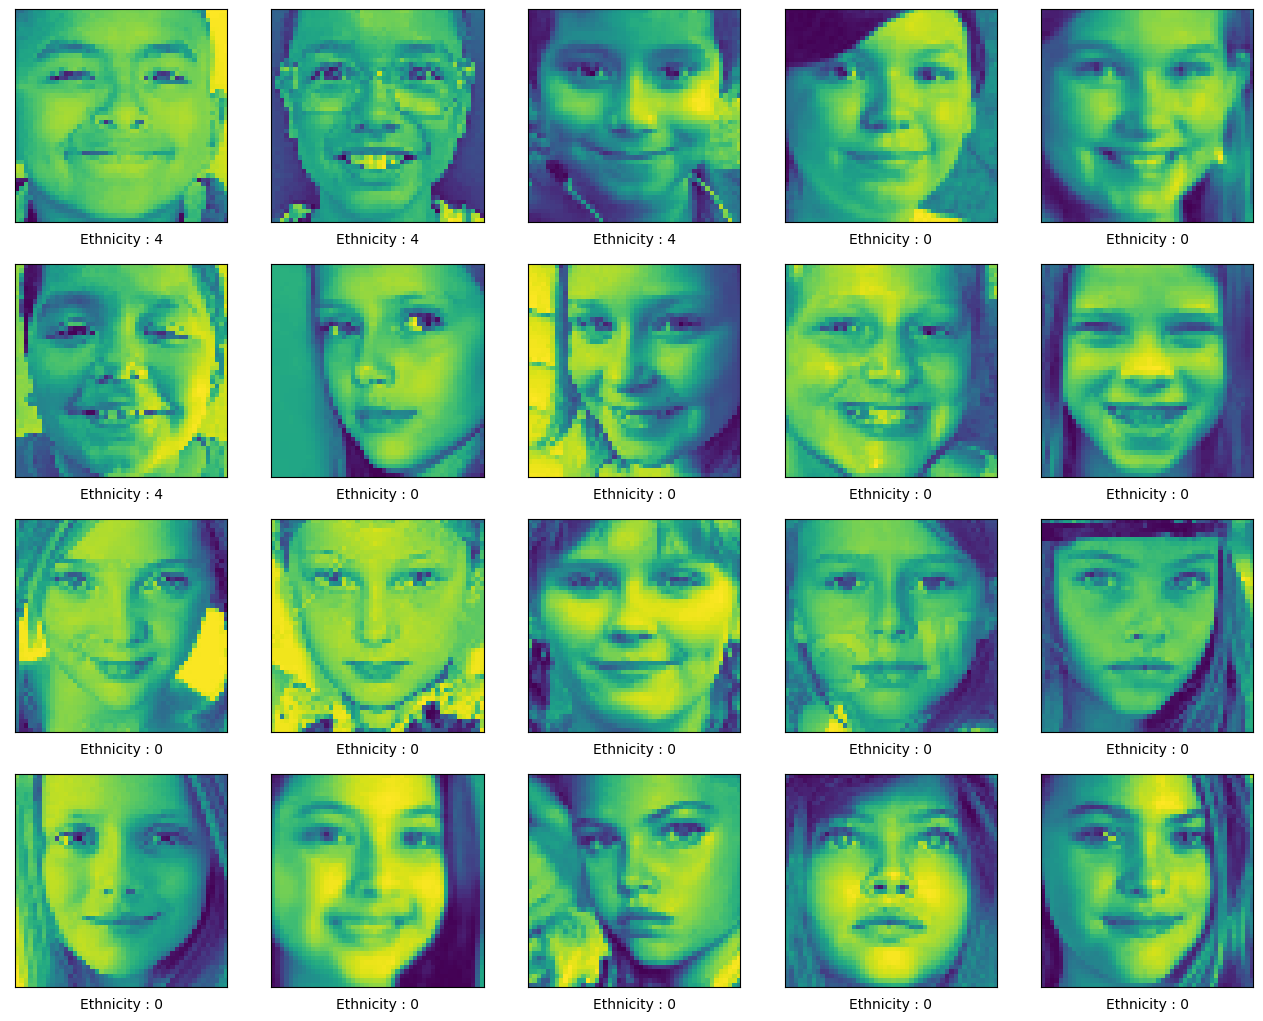

In [72]:
plt.figure(figsize=(16,16))

for i in range(1500,1520):
    plt.subplot(5,5,(i%25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df['pixels'].iloc[i].reshape(48,48))
    plt.xlabel(
    "Ethnicity : " + str(df['ethnicity'].iloc[i])
    )
plt.show()

## Data Science analysis

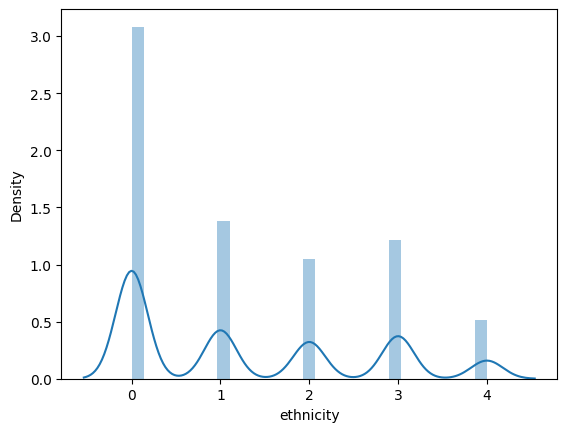

In [73]:
sns.distplot(a=df['ethnicity'])
names_ethnicity = ['White', 'Black', 'Asian', 'Indian', 'Other']

## Model Creation

### split data: taking y ='ethnicity'

In [74]:
y = df['ethnicity']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.22,random_state=42)

In [75]:
class Custom(Callback):
    def on_epoch_end(self,epochs,logs={}):
        if logs.get("val_acc") > 0.750:
            print("Reached acc 75% !")
            self.model.stop_training= True
    
callback = Custom()
callbacks= [callback]

In [76]:
model_eth = Sequential([
    InputLayer((48, 48, 1)),
    Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5)
    
])

model_eth.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='rmsprop', metrics=['acc'])

In [77]:
model_eth.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 6400)              0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [78]:
history  = model_eth.fit(x_train, y_train, epochs=16, validation_split=0.1, batch_size=64, callbacks=callbacks)

Epoch 1/16


2022-11-07 12:03:57.284577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


260/260 [==============================] - ETA: 0s - loss: 1.2468 - acc: 0.5248

2022-11-07 12:04:01.576925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


260/260 [==============================] - 5s 17ms/step - loss: 1.2468 - acc: 0.5248 - val_loss: 1.0275 - val_acc: 0.6479
Epoch 2/16
260/260 [==============================] - 4s 16ms/step - loss: 0.9888 - acc: 0.6496 - val_loss: 0.8437 - val_acc: 0.7171
Epoch 3/16
260/260 [==============================] - 4s 16ms/step - loss: 0.8793 - acc: 0.6971 - val_loss: 0.7966 - val_acc: 0.7047
Epoch 4/16
260/260 [==============================] - 4s 16ms/step - loss: 0.8240 - acc: 0.7155 - val_loss: 0.7317 - val_acc: 0.7588


,loss,acc,val_loss,val_acc
0,1.246777,0.524820,1.027505,0.647918
1,0.988766,0.649579,0.843656,0.717144
2,0.879296,0.697115,0.796584,0.704705
3,0.824008,0.715505,0.731715,0.758789


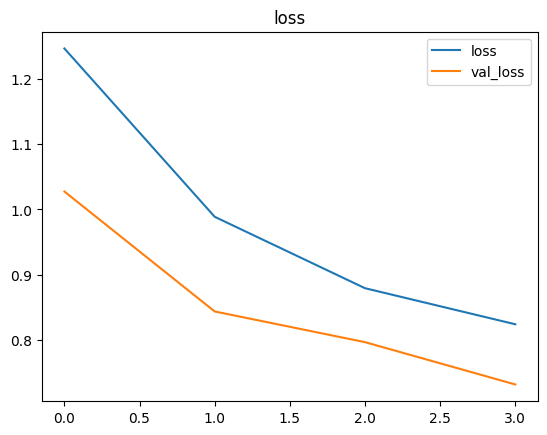

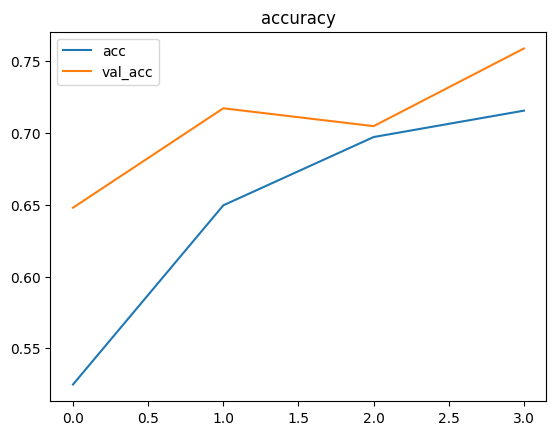

In [79]:
history_df = pd.DataFrame(history.history)
history_df[['loss','val_loss']].plot(title='loss')
history_df[['acc','val_acc']].plot(title='accuracy')
history_df

In [80]:
loss,acc = model_eth.evaluate(x_test,y_test)
acc

163/163 [==============================] - 1s 6ms/step - loss: 0.7380 - acc: 0.7450


0.7450153827667236

##  Make Predictions

### from the dataset

type: <class 'numpy.ndarray'>, shape: (2304,) 


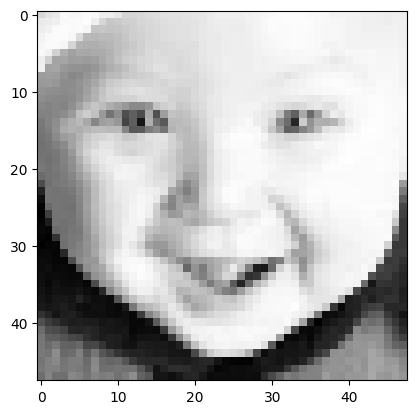

In [81]:
ind = 458
print(f"type: {type(df['pixels'].iloc[ind])}, shape: {df['pixels'].iloc[ind].shape} ")
img = df['pixels'].iloc[ind].reshape(48,48)

plt.imshow(img, cmap='gray')
plt.show()

In [82]:
teth =df['ethnicity'].iloc[ind] # True Ethnicty 
print("True ethnicity: ", names_ethnicity[teth])
type(teth), teth.shape, type(img), img.shape

True ethnicity:  White


(numpy.int64, ())

In [84]:
def predict(model_, img):
    pred = np.argmax(model_.predict(img), axis=1)
    return pred

In [85]:
img = img.reshape(-1,48,48,1)

eth = predict(model_eth, img)[0]
print("Predict ethnicity: ", names_ethnicity[eth])

1/1 [==============================] - 0s 51ms/step
Predict ethnicity:  White


2022-11-07 12:04:15.800142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


### test image

In [86]:
rand_image_full_path

'./test-data/download.jpg'

In [87]:
from PIL import Image

testimage = Image.open(rand_image_full_path)
testimage = testimage.resize((48, 48), Image.ANTIALIAS)
testimage = testimage.convert('L')

testimage_np = np.asarray(testimage)
type(testimage_np), testimage_np.shape

(numpy.ndarray, (48, 48))

In [88]:
testimage_flatten = testimage_np.flatten()
testimage_flatten

array([243, 243, 243, ..., 238, 238, 238], dtype=uint8)

In [89]:
type(testimage_flatten), testimage_flatten.shape

(numpy.ndarray, (2304,))

In [90]:
testimage_series = pd.Series(testimage_flatten) 
testimage_series

0       243
1       243
2       243
3       243
4       243
       ... 
2299    239
2300    238
2301    238
2302    238
2303    238
Length: 2304, dtype: uint8

In [91]:
test_image_pixels = testimage_series.apply(lambda x : x/255)
test_image_pixels

0       0.952941
1       0.952941
2       0.952941
3       0.952941
4       0.952941
          ...   
2299    0.937255
2300    0.933333
2301    0.933333
2302    0.933333
2303    0.933333
Length: 2304, dtype: float64

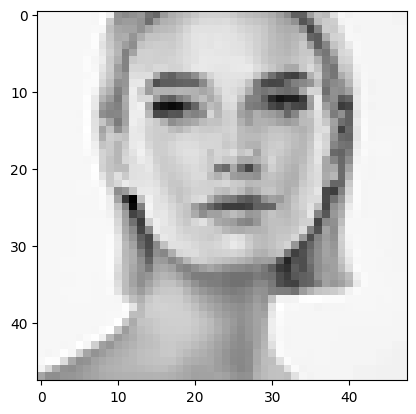

In [92]:
plt.imshow(testimage, cmap='gray')
plt.show()

In [93]:
testimage = testimage_np.reshape(-1,48,48,1)
type(testimage), testimage.shape

(numpy.ndarray, (1, 48, 48, 1))

In [94]:
testimage_eth = predict(model_eth, testimage)[0]
print("Test Image - Predict ethnicity: ", names_ethnicity[testimage_eth])

1/1 [==============================] - 0s 52ms/step
Test Image - Predict ethnicity:  White


2022-11-07 12:04:16.254259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
